# Basic Astronomical Classification
In this notebook, we will explore a common machine learning problem in astronomy: classification. In particular we are going to look at classifying sources as quasars (extremely powerful supermassive black holes) vs. galaxies. While these are clearly physically distinct phenomena, they often-times look VERY similar in a telescope. In order to distinguish the two sources, we are going to use the "colors" of the spectra. Colors represent the difference between two magnitudes (integrated flux of the spectra over a band pass with some correction factors). 

**Please ask about the astronomy if you are interested!**


![alt text](plot_sdss_filters_11.png "SDSS Filters")


The sources we are going to look at have the following four colors: [u-g, g-r, r-i, i-z].

The first three pieces of this code were taken from AstroML: https://www.astroml.org/examples/datasets/plot_sdss_galaxy_colors.html

In [1]:
!pip install astroML

In [78]:
from matplotlib import pyplot as plt
from astroML.datasets import fetch_sdss_galaxy_colors
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Flatten, Dropout
from keras.optimizers import SGD, Adam
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

In [79]:
# Download data
data = fetch_sdss_galaxy_colors()
data = data[::10]  # truncate for plotting

# Extract colors and spectral class: [u-g, g-r, r-i, i-z]
ug = data['u'] - data['g']
gr = data['g'] - data['r']
ri = data['r'] - data['i']
iz = data['i'] - data['z']
color_vec = np.array([ug, gr]).T#, ri, iz]).T
spec_class = data['specClass']
print(np.unique(spec_class))
galaxies = (spec_class == 'GALAXY')
qsos = (spec_class == 'QSO')

['GALAXY' 'QSO']


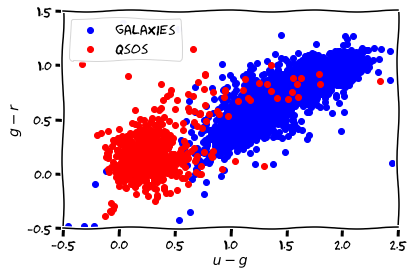

In [80]:
# Let's take a quick look at some of the colors!
with plt.xkcd():
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 1.5)

    ax.scatter(ug[galaxies], gr[galaxies], c='b', label='galaxies')
    ax.scatter(ug[qsos], gr[qsos], c='r', label='qsos')

    ax.legend(loc=2)

    ax.set_xlabel('$u-g$')
    ax.set_ylabel('$g-r$')

    plt.show()

# Machine Learning
Now that we have the color vectors and labels, let's look at applying a basic machine learning algorithm to do the classification!

In [81]:
#temp = list(zip(color_vec, spec_class)) 
#random.shuffle(temp) 
#color_vec, spec_class = zip(*temp) 

train_per = int(0.8*len(color_vec))
#Let's make our training and test sets
X_train = color_vec[:train_per]
Y_train = spec_class[:train_per]
X_test = color_vec[train_per:]
Y_test = spec_class[train_per:]

print(len(X_train), len(X_test))

Y_train_enc = []
for val in Y_train:
    if val == 'GALAXY':
        Y_train_enc.append(0)
    else:
        Y_train_enc.append(1)
Y_test_enc = []
for val in Y_test:
    if val == 'GALAXY':
        Y_test_enc.append(0)
    else:
        Y_test_enc.append(1)

4000 1000


In [82]:
activation = 'relu'  # activation function
initializer = 'normal'  # model initializer
max_epochs = 15  # maximum number of interations
lr = 0.001  # initial learning rate
loss_function = 'sparse_categorical_crossentropy'
metrics_ = ['accuracy', 'mae', 'mse']

model = Sequential([
    Dense(units=100, kernel_initializer=initializer, activation=activation),
    Dropout(0.5),
    Dense(units=100, kernel_initializer=initializer, activation=activation),
    Dense(2, activation='softmax'),
])

optimizer = SGD(lr=lr)
#optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_)

## Now that we have everything defined, let's train and test the network

In [83]:
model.fit(X_train, np.array(Y_train_enc))
model.summary()

125/125 [==============================] - 1s 8ms/step - loss: 0.2626 - accuracy: 0.8783 - mae: 0.5000 - mse: 0.4019
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             multiple                  300       
_________________________________________________________________
dropout_10 (Dropout)         multiple                  0         
_________________________________________________________________
dense_31 (Dense)             multiple                  10100     
_________________________________________________________________
dense_32 (Dense)             multiple                  202       
Total params: 10,602
Trainable params: 10,602
Non-trainable params: 0
_________________________________________________________________


In [84]:
test_predictions = model.predict(X_test)
print(test_predictions)
len(test_predictions)

[[0.99437016 0.00562987]
 [0.96838063 0.0316194 ]
 [0.99483216 0.00516784]
 ...
 [0.99697363 0.00302639]
 [0.9294936  0.07050642]
 [0.9901383  0.00986167]]


1000

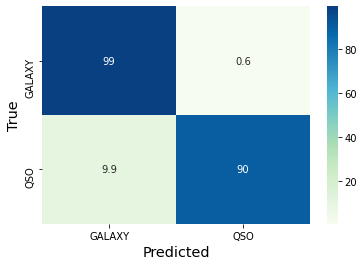

In [86]:
predictions = [np.argmax(pred) for pred in test_predictions]

matrix_conf = confusion_matrix(Y_test_enc,predictions)

# Normalize confusion matrix
matrix_conf = matrix_conf.astype('float64') 
norm_fac = np.sum(matrix_conf[:], axis=1)
for row in range(matrix_conf.shape[0]):
    matrix_conf[row,:] = np.round(matrix_conf[row,:]*(1/norm_fac[row]),3)*100
# Plot confusion matrix    
sns_plot = sns.heatmap(matrix_conf, annot=True, cmap='GnBu', xticklabels=['GALAXY', 'QSO'], yticklabels=['GALAXY', 'QSO'])
#sns_plot.set(xticklabels=np.arange(1,5))
#sns_plot.set(yticklabels=np.arange(1,5))
plt.ylabel('True', fontsize='x-large')
plt.xlabel('Predicted', fontsize='x-large')
sns_fig = sns_plot.get_figure()
#sns_fig.savefig('Confusion-Matrix.pdf', type='pdf')